In [106]:
import pandas as pd
import numpy as np
import re 

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [12]:
pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e2/63/379617e3d982e8a66c9d66ebf4621d3357c7c18ad356473c335bffd5aba6/catboost-1.2.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.2/101.0 MB 4.1 MB/s eta 0:00:25
   ---------------------------------------- 1.0/101.0 MB 10.9 MB/s eta 0:00:10
    --------------------------------------- 1.5/101.0 MB 12.0 MB/s eta 0:00:09
    --------------------------------------- 2.1/101.0 MB 10.9 MB/s eta 0:00:10
   - -------------------------------------- 2.8/101.0 MB 12.0 MB/s eta 0:00:09
   - -------------------------------------- 3.9/101.0 MB 14.0 MB/s eta 0:00:07
   -- ------------------------------------- 5.3/101.0 MB 16.0 MB/s eta 0:00:06
   -- ---------

In [80]:
!pip install wordcloud 

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 300.2/300.2 kB 9.4 MB/s eta 0:00:00


In [59]:
from catboost import CatBoostRegressor

In [19]:
pip install missingno

In [60]:
import missingno as msno
plt.rcParams['figure.dpi'] = 140

In [193]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

### 결측값 확인

In [149]:
train_df.isnull().sum()

ID                     0
User-ID                0
Book-ID                0
Book-Rating            0
Age                    0
Location               0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

<Axes: >

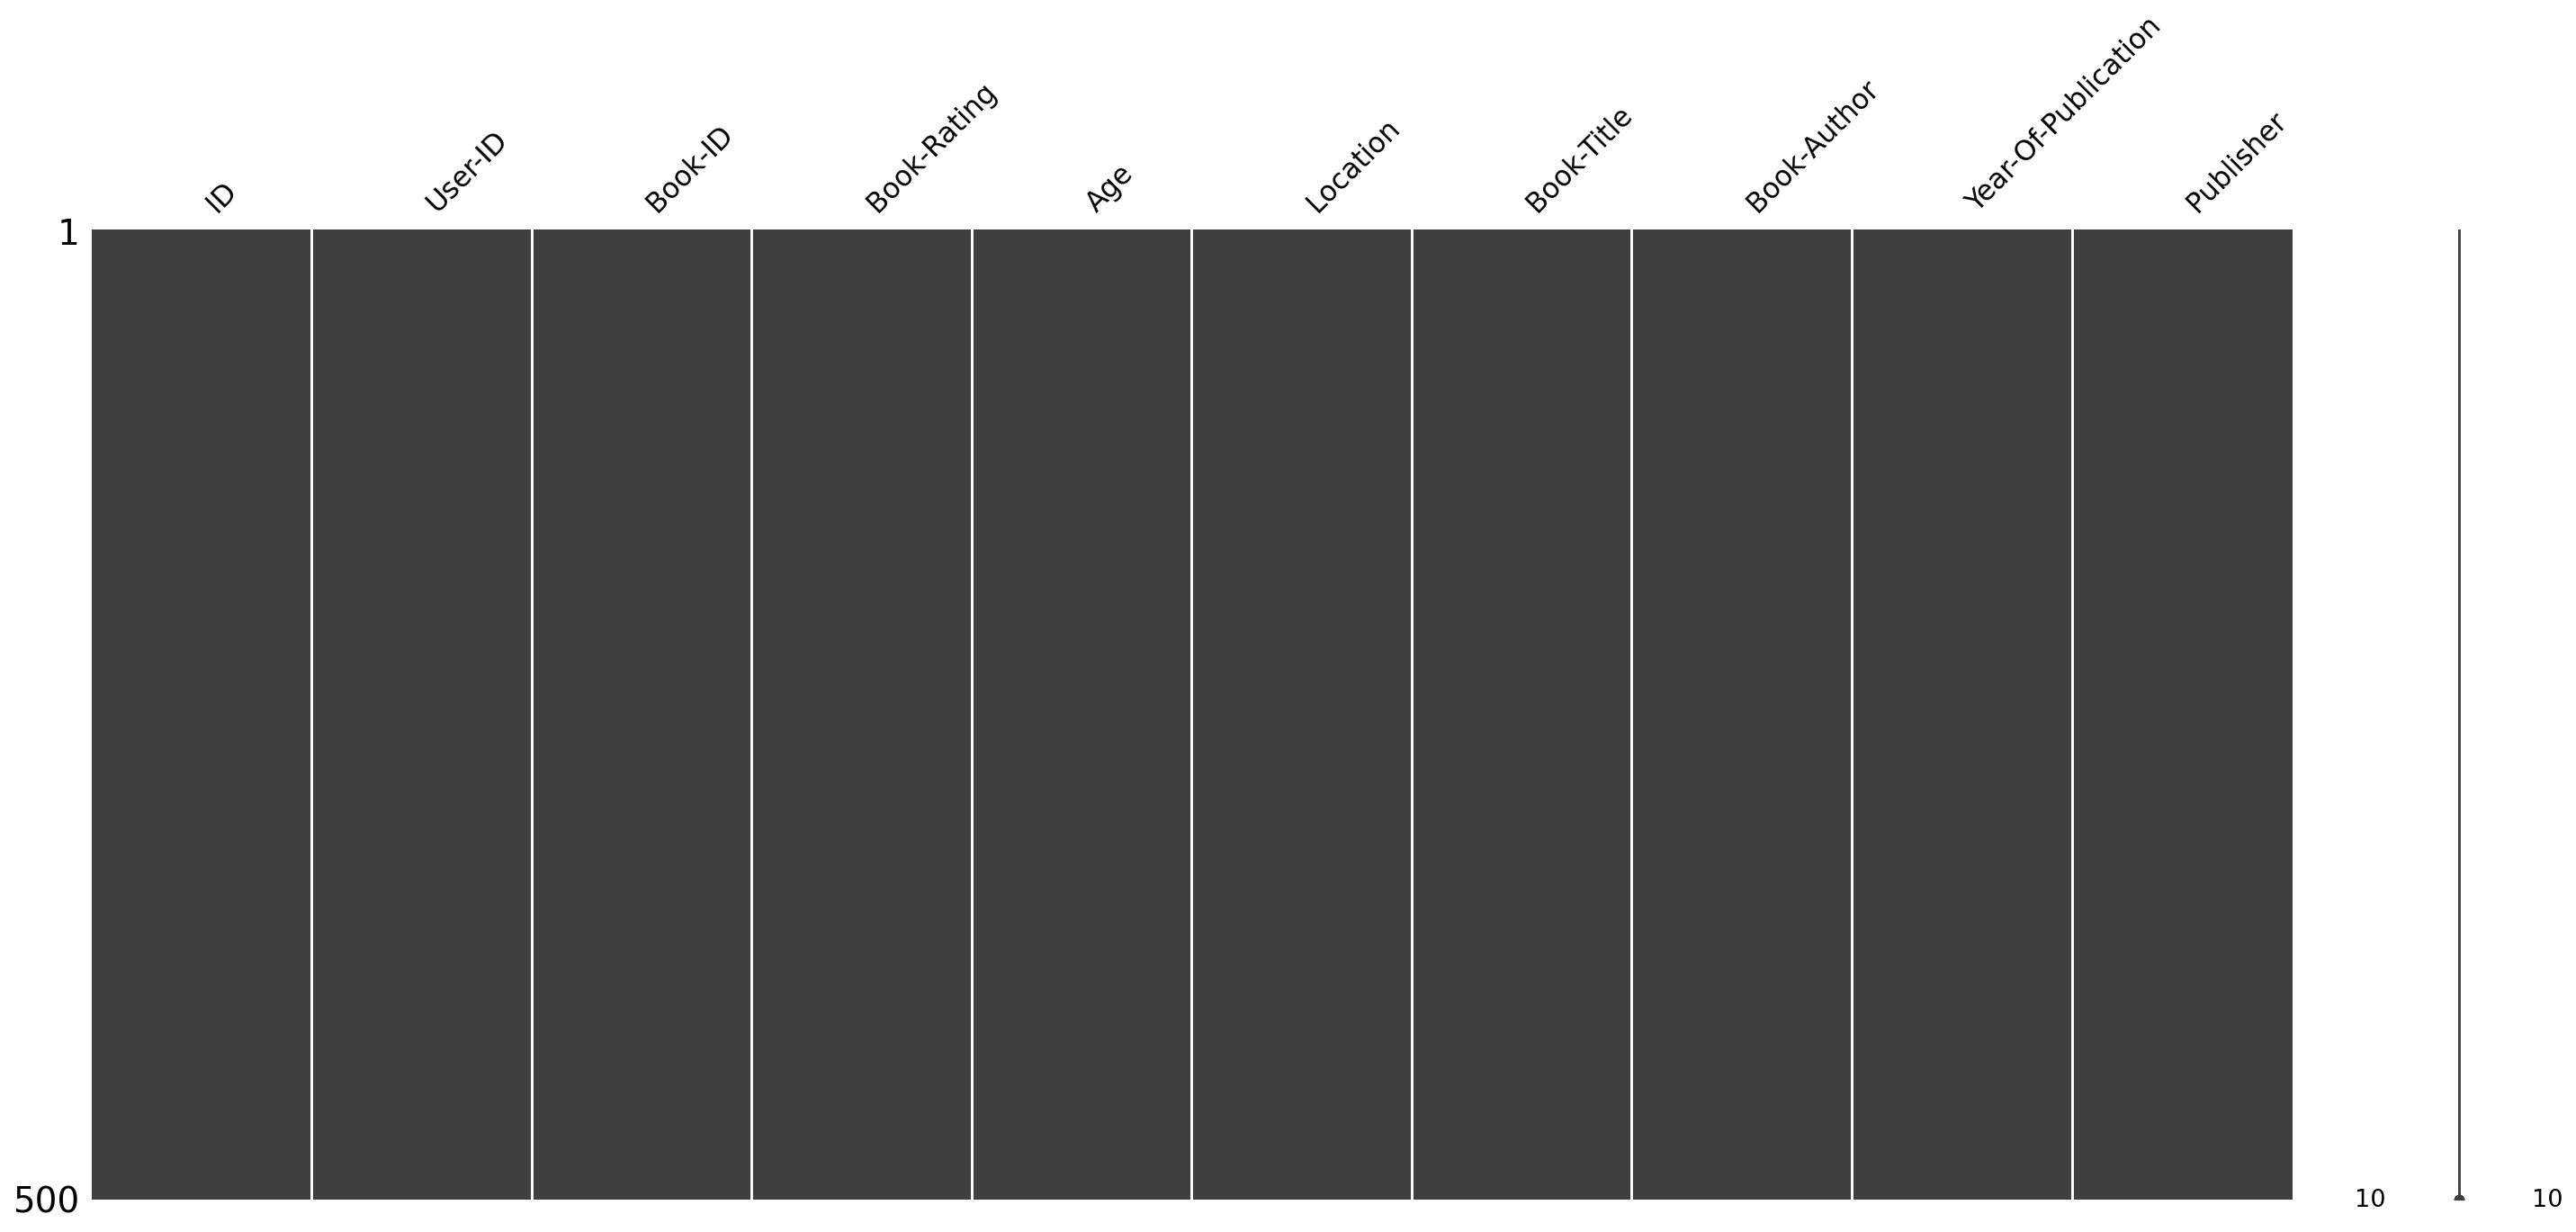

In [21]:
msno.matrix(train_df.sample(500)) 

<Axes: >

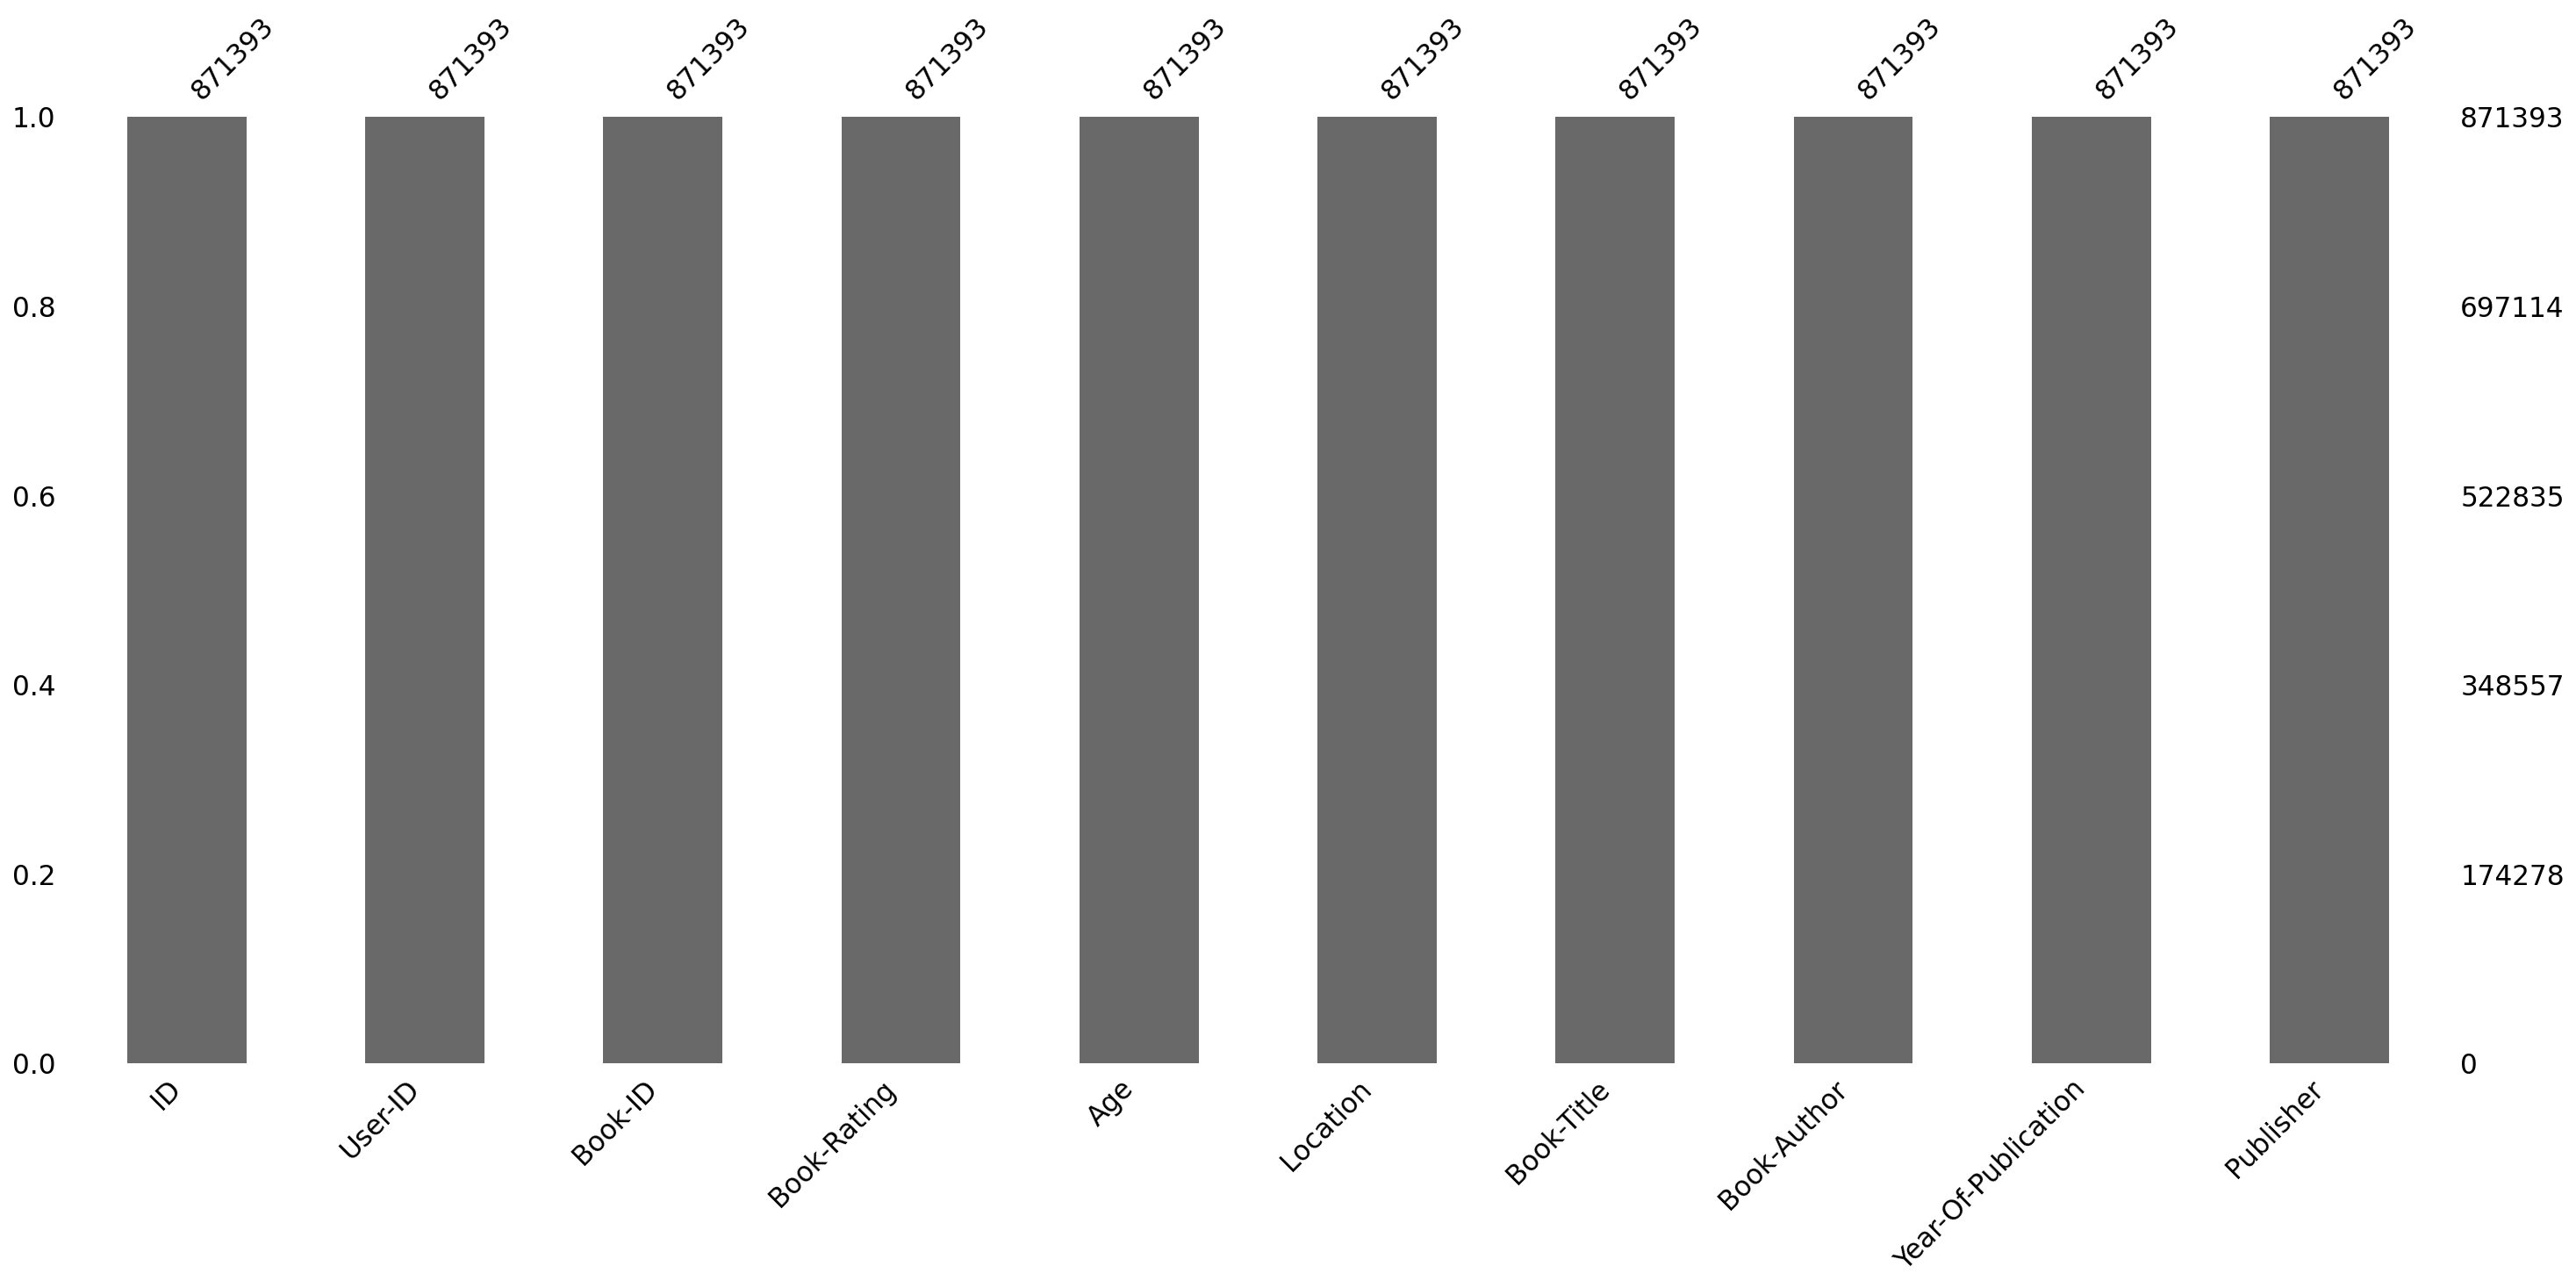

In [22]:
msno.bar(train_df)

## Year-Of-Publication 전처리

In [184]:
# train_df['Year-Of-Publication'].dtype

dtype('float64')

In [185]:
# train_df['Year-Of-Publication'] = pd.to_datetime(train_df['Year-Of-Publication'])

In [186]:
# train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871393 entries, 0 to 871392
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   871393 non-null  object        
 1   User-ID              871393 non-null  object        
 2   Book-ID              871393 non-null  object        
 3   Book-Rating          871393 non-null  int64         
 4   Age                  871393 non-null  float64       
 5   Location             871393 non-null  object        
 6   Book-Title           871393 non-null  object        
 7   Book-Author          871393 non-null  object        
 8   Year-Of-Publication  871393 non-null  datetime64[ns]
 9   Publisher            871393 non-null  object        
 10  Age-Group            871393 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 67.3+ MB


In [190]:
# train_df['Year']= train_df['Year-Of-Publication'].dt.year

0         1970
1         1970
2         1970
3         1970
4         1970
          ... 
871388    1970
871389    1970
871390    1970
871391    1970
871392    1970
Name: Year-Of-Publication, Length: 871393, dtype: int64

## Book-Author 전처리

In [68]:
train_df['Book-Author-lower'] = train_df['Book-Author'].apply(lambda x : text_preprocessing(x))

In [69]:
train_df['Book-Author-lower'].value_counts()

stephenking        8590
johngrisham        7927
noraroberts        7072
jamespatterson     5020
daniellesteel      4236
                   ... 
errolselkirk          1
bernalcpayne          1
francisxking          1
jamesrgroff           1
stephengriffith       1
Name: Book-Author-lower, Length: 88051, dtype: int64

In [70]:
def find_author(author_list:str):
    if author_list in ['joannekrowling','rowlingjk']:
        return 'jkrowling'
    if author_list in ['shakespeare', 'normanshakespeare','edfredsontbowersshakespeare']:
        return 'williamshakespeare'
    if author_list in ['guillermoshakespeare']:
        return 'victorhugo'
    return author_list

In [71]:
train_df['Book-Author']=train_df['Book-Author'].apply(lambda x : find_author(x))

## Location 전처리

In [72]:
train_df['Location'].value_counts()

toronto, ontario, canada                 12267
n/a, n/a, n/a                            11161
chicago, illinois, usa                    7214
seattle, washington, usa                  6967
ottawa, ontario, canada                   6915
                                         ...  
qom, n/a, iran                               1
warlingham, england, united kingdom          1
pfäffikon, nebraska, switzerland             1
puerto vallarta, mexico, usa                 1
castiglion fiorentino, toscana, italy        1
Name: Location, Length: 20971, dtype: int64

In [73]:
train_df.Location.str.count(',')

0         2
1         2
2         2
3         2
4         2
         ..
871388    2
871389    2
871390    2
871391    2
871392    2
Name: Location, Length: 871393, dtype: int64

In [74]:
def select_string_based_on_spaces(text):
    # 단어 사이의 공백 수 세기
    space_count = text.count(',')

    # 조건에 따라 문자열 선택
    if space_count == 3:
        selected_text = text.split(',')[3].strip()
    elif space_count == 2:
        selected_text = text.split(',')[2].strip()
    else:
        selected_text = "Invalid space count"

    return selected_text

result_1 = train_df['Location'].apply(select_string_based_on_spaces)
print(result_1)

0         canada
1         canada
2         canada
3         canada
4         canada
           ...  
871388       usa
871389       usa
871390    canada
871391       usa
871392     italy
Name: Location, Length: 871393, dtype: object


In [75]:
result_1.unique()

array(['canada', 'usa', 'germany', 'spain', 'australia', 'united kingdom',
       '', 'italy', 'netherlands', 'portugal', 'sweden', 'austria',
       'france', 'finland', 'new zealand', 'singapore', 'switzerland',
       'philippines', 'españa', 'malaysia', 'belgium', 'japan', 'denmark',
       'belize', 'england', 'poland', 'ireland', 'haiti',
       'trinidad and tobago', 'deutschland', 'tanzania', 'moldova',
       'bulgaria', 'luxembourg', 'south africa', 'czech republic',
       'israel', 'malta', 'petrolwar nation', 'kuwait', 'peru', 'ecuador',
       'south korea', 'turkey', 'nigeria', 'brazil', 'hungary',
       'indonesia', 'kazakhstan', 'india', 'china', 'egypt', 'croatia',
       'taiwan', 'argentina', 'chile', 'venezuela', 'galiza', 'iceland',
       'scotland', 'bolivia', 'lithuania', 'norway', 'mexico', 'bahamas',
       'united sates', 'romania', 'iran', 'dominican republic',
       'maricopa', 'the world tomorrow', 'andorra', 'galiza neghra',
       'jersey', 'ghana', '

In [76]:
train_df['try']=result_1

In [77]:
train_df.columns

Index(['ID', 'User-ID', 'Book-ID', 'Book-Rating', 'Age', 'Location',
       'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Book-Author-lower', 'try'],
      dtype='object')

In [19]:
train_df['try'].dtype

dtype('O')

#### 전처리 함수1

In [65]:
import re
def text_preprocessing(summary):
    summary = re.sub("[.,\'\"''""!?' ']", "", summary)
    summary = re.sub("[^0-9a-zA-Z\\s]", "", summary)
    summary = summary.lower()
    return summary

In [66]:
train_df['try'] = train_df['try'].apply(lambda x : text_preprocessing(x))

KeyError: 'try'

#### 전처리 함수2

In [67]:
def find_country(country_list:str):
    if country_list in ['galiza']:
        return 'spain'
    elif country_list in ['united sates','maricopa','richmond country','framingham','usa (currently living in england)','saint loius','shelby',
                     'los estados unidos de norte america','united states','polk','u.s.a.','morgan','us','ventura county','hernando','kern',
                     'onondaga nation','disgruntled states of america','san mateo','united state','aroostook','guam','fort bend',
                      'hungary and usa','u.s. of a.','united staes','america','alachua','u.s>']:
        return 'usa'
    elif country_list in ['the world tomorrow', 'galiza neghra','universe','Invalid space count','n/a','tdzimi','space','here and there',
                     'cherokee','csa','x','we`re global!','unknown','nz','ysa','n/a - on the road','the great white north','far away...',
                      'quit','k1c7b1','caribbean sea','st.thomasi','rutherford','"n/a"','the','st. helena','c',
                      'everywhere and anywhere']:
        return 'unknown'
    elif country_list in ['jersey','la france']:
        return ' france' 
    elif country_list in ['catalunya','lleida','catalonia','berguedà','catalunya spain','madrid','orense']:
        return ' spain'
    elif country_list in [' la chine éternelle !',' macau']:
        return ' china'
    elif country_list in ['alderney','worcester','guernsey','prince william','bermuda','cayman islands','channel islands','u.k.',
                     'camden']:
        return 'united kingdom'
    elif country_list in ['collin']:
        return 'czech republic'
    elif country_list in ['burma']:
        return 'myanmar'
    elif country_list in ['united arab emirates']:
        return 'u.a.e'
    elif country_list in ['pender']:
        return 'poland'
    elif country_list in ['tobago']:
        return 'trinidad and tobago'  
    elif country_list in ['urugua']:
        return 'uruguay'
    elif country_list in ['ferrara','italia','l`italia']:
        return 'italy'
    elif country_list in ['niger']:
        return 'nigeria'
    elif country_list in ['la belgique']:
        return 'belgium'
    elif country_list in ['burlington','cananda']:
        return 'canada'
    return country_list   


In [78]:
train_df['try'] = train_df['try'].apply(lambda x : find_country(x))

In [79]:
train_df['try'].value_counts()

usa                       630376
canada                     78564
united kingdom             27173
germany                    23471
                           21012
                           ...  
rwanda                         1
marshall islands               1
macau                          1
burkina faso                   1
bosnia and herzegovina         1
Name: try, Length: 160, dtype: int64

#### 컬럼 이름 Country로 변환

In [80]:
train_df = train_df.rename(columns={'try':'Country'})

In [81]:
train_df.columns

Index(['ID', 'User-ID', 'Book-ID', 'Book-Rating', 'Age', 'Location',
       'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Book-Author-lower', 'Country'],
      dtype='object')

#### Country 정보가 없는 사람 리스트 생성

In [46]:
#train_no_country = train_df[train_df['Country']=='other'][['ID','Book-ID']]

In [210]:
#train_no_country.head()

,ID,Book-ID
70367,TRAIN_070367,BOOK_001259
70368,TRAIN_070368,BOOK_001928
70369,TRAIN_070369,BOOK_015521
70370,TRAIN_070370,BOOK_017517
70371,TRAIN_070371,BOOK_021411


#### Country가 명확하지 않은 유저 채우기

In [211]:
#book_country_info = train_df.groupby(['Book-ID','Country'])['Country'].count().groupby('Book-ID').idxmax().reset_index()
#book_country_info

,Book-ID,Country
0,BOOK_000001,"(BOOK_000001, unitedkingdom)"
1,BOOK_000002,"(BOOK_000002, usa)"
2,BOOK_000003,"(BOOK_000003, australia)"
3,BOOK_000004,"(BOOK_000004, usa)"
4,BOOK_000005,"(BOOK_000005, usa)"
...,...,...
243436,BOOK_270051,"(BOOK_270051, usa)"
243437,BOOK_270052,"(BOOK_270052, unitedkingdom)"
243438,BOOK_270053,"(BOOK_270053, usa)"
243439,BOOK_270054,"(BOOK_270054, usa)"


## Age 전처리 

#### IQR기법으로 Age 이상치 제거

In [206]:
def outlier_iqr(data, column):
    global lower, upper
    q1, q3 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)
    iqr = q3 - q1
    cut_off = iqr * 1.5
    lower, upper = q1 - cut_off, q3 + cut_off
    print('iqr은', iqr, '이다.')
    print('lower은', lower, '이다.')
    print('upper은', upper, '이다.')
    
    data1 = data[data[column] > upper]
    data2 = data[data[column] < lower]
    print('총 이상값 개수는', data1.shape[0] + data2.shape[0], '이다.')
    return pd.concat([data1, data2])
    
outlier_iqr(train_df, 'Age')

iqr은 10.0 이다.
lower은 16.0 이다.
upper은 56.0 이다.
총 이상값 개수는 61776 이다.


,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Year-Of-Publication-Group
143,TRAIN_000143,USER_00025,BOOK_200309,8,58.0,"severna park, maryland, usa",Houses of Stone,Barbara Michaels,1993.0,Simon &amp; Schuster,1990
145,TRAIN_000145,USER_00027,BOOK_212987,7,68.0,"kirkland, washington, usa",The Stone Carvers,Jane Urquhart,2002.0,Viking Books,2000+
314,TRAIN_000314,USER_00071,BOOK_184599,7,69.0,"thunder bay, ontario, canada",The Long Road Home,Danielle Steel,1999.0,Dell Publishing Company,1990
401,TRAIN_000401,USER_00087,BOOK_076132,8,61.0,"anchorage, alaska, usa",The King of the Fields,Isaac Bashevis Singer,1989.0,Penguin USA,1980
482,TRAIN_000482,USER_00110,BOOK_098600,8,66.0,"marietta, georgia, usa",Floaters,Joseph Wambaugh,1996.0,Bantam,1990
...,...,...,...,...,...,...,...,...,...,...,...
870913,TRAIN_870913,USER_92086,BOOK_221348,0,0.0,"mountain view, california, usa",The Quotable Climber,Jonathan Waterman,2002.0,Lyons Press,2000+
870914,TRAIN_870914,USER_92086,BOOK_222040,0,0.0,"mountain view, california, usa",A Kind of Grace: A Treasury of Sportswriting b...,Ron Rapoport,1994.0,Zenobia Press,1990
870915,TRAIN_870915,USER_92086,BOOK_230499,0,0.0,"mountain view, california, usa",Triathlon Swimming Made Easy: How Anyone Can S...,Terry Laughlin,2002.0,Total Immersion Inc.,2000+
870916,TRAIN_870916,USER_92086,BOOK_231726,9,0.0,"mountain view, california, usa",A Passion for Golf: The Best of Golf Writing,Bishop Schuyler,1999.0,St Martins Pr,1990


C:\Users\lgh63\AppData\Local\Temp\ipykernel_25496\1644573700.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.Age, bins=50, kde=False)


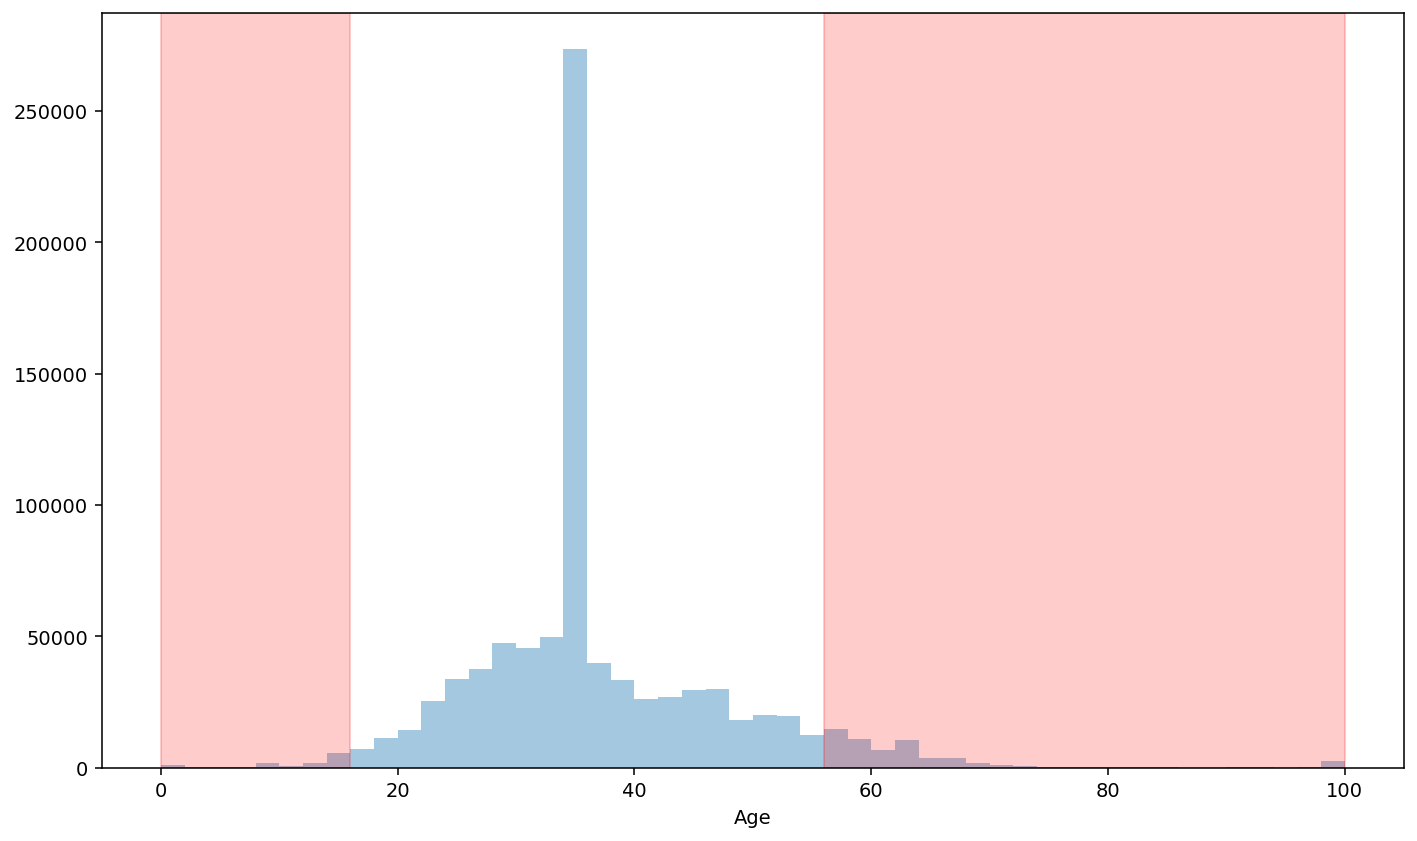

In [207]:
import seaborn as sns

plt.figure(figsize=(12,7))
sns.distplot(train_df.Age, bins=50, kde=False)
plt.axvspan(xmin=lower, xmax=train_df.Age.min(), alpha=0.2,color='red')
plt.axvspan(xmin=upper, xmax=train_df.Age.max(), alpha = 0.2, color='red')
plt.show();

In [152]:
no_outlier_Age = train_df[(train_df['Age'] < upper) | (train_df['Age'] > lower)]
len(no_outlier_Age)

871393

In [153]:
outlier_Age = train_df[(train_df['Age']> upper) | (train_df['Age']<lower)]
len(outlier_Age)

61776

In [154]:
outlier_index_Age = [outlier_Age.index]
outlier_index_Age

[Int64Index([   143,    145,    176,    314,    401,    475,    482,    483,
                522,    526,
             ...
             870908, 870909, 870910, 870911, 870912, 870913, 870914, 870915,
             870916, 870917],
            dtype='int64', length=61776)]

In [208]:
# 100세 이상인 Age값을 100으로 변환
train_df.loc[train_df['Age']>100,'Age'] = 100

#### Age 범주형으로 변환

In [209]:
bins=[-1,5,12,18,29,49,64,float('inf')]
labels=['0-5','6-12','13-18','19-29','30-49','50-64','65+']
train_df['Age-Group']=pd.cut(train_df['Age'],bins=bins,labels=labels)

In [210]:
train_df['Age-Group'].value_counts()

30-49    572843
19-29    162946
50-64     95909
13-18     20939
65+       14096
6-12       3047
0-5        1613
Name: Age-Group, dtype: int64

## Publication 전처리

#### IQR기법으로 Publication이상치 제거

In [195]:
outlier_iqr(train_df, 'Year-Of-Publication')

iqr은 10.0 이다.
lower은 1976.0 이다.
upper은 2016.0 이다.
총 이상값 개수는 26344 이다.


,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
1426,TRAIN_001426,USER_00214,BOOK_013167,6,35.0,"sherwood park, alberta, canada",MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2021.0,Aladdin
22254,TRAIN_022254,USER_02386,BOOK_264485,9,29.0,"rheinfelden, baden-wuerttemberg, germany",Das groÃ?Â?e BÃ?Â¶se- MÃ?Â¤dchen- Lesebuch.,Kathy Lette,2021.0,Goldmann
38770,TRAIN_038770,USER_03733,BOOK_013167,8,49.0,"indiana, pennsylvania, usa",MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2021.0,Aladdin
39329,TRAIN_039329,USER_03733,BOOK_268194,8,49.0,"indiana, pennsylvania, usa",MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,Coville,2021.0,Aladdin
39432,TRAIN_039432,USER_03753,BOOK_148201,9,45.0,"montreal, , canada",FOREST PEOPLE (Touchstone Books (Hardcover)),Colin M. Turnbull,2021.0,Simon &amp; Schuster
...,...,...,...,...,...,...,...,...,...,...
871300,TRAIN_871300,USER_92093,BOOK_216824,0,37.0,"lakewood, colorado, usa",Girlfriends,Jayne Wexler,-1.0,Running Press
871319,TRAIN_871319,USER_92093,BOOK_224878,9,37.0,"lakewood, colorado, usa",Little Town on the Prairie,Laura Ingalls Wilder,1953.0,HarperTrophy
871324,TRAIN_871324,USER_92093,BOOK_228601,6,37.0,"lakewood, colorado, usa",Farmer Boy (Little House),Laura Ingalls Wilder,1953.0,HarperTrophy
871331,TRAIN_871331,USER_92093,BOOK_232831,0,37.0,"lakewood, colorado, usa",Too Late the Phalarope,Alan Paton,1950.0,Scribner Book Company


C:\Users\lgh63\AppData\Local\Temp\ipykernel_25496\1413182216.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['Year-Of-Publication'],bins=50,kde=False)


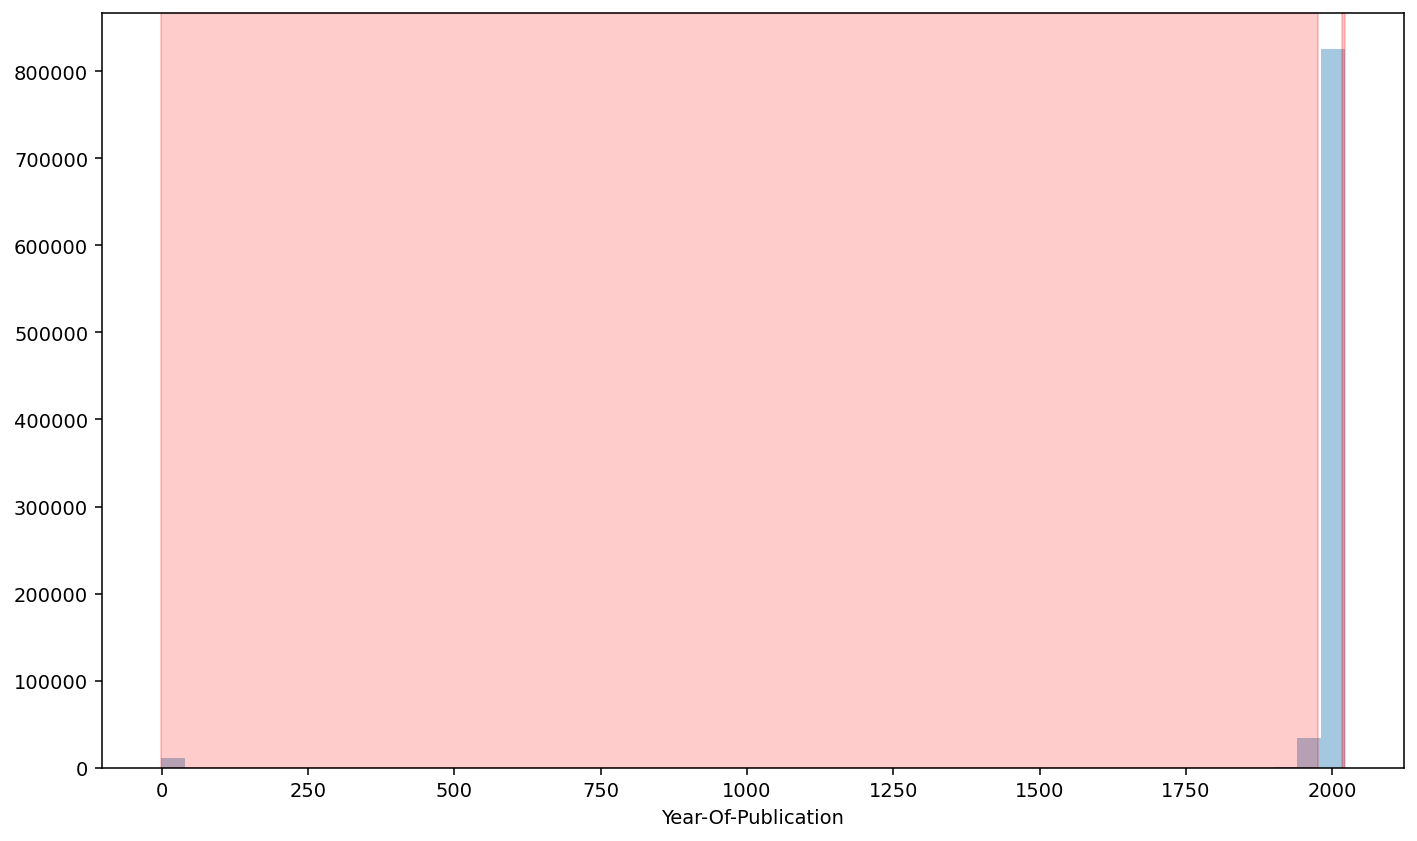

In [196]:
# Year-Of-Publication 1976이하인 경우 1976으로 변환, 2016이상인 경우 2016으로 변환
import seaborn as sns

plt.figure(figsize=(12,7))
sns.distplot(train_df['Year-Of-Publication'],bins=50,kde=False)
plt.axvspan(xmin=lower,xmax=train_df['Year-Of-Publication'].min(),alpha=0.2, color='red')
plt.axvspan(xmin=upper,xmax=train_df['Year-Of-Publication'].max(),alpha=0.2, color='red')
plt.show();

In [145]:
no_outlier_Pub= train_df[(train_df['Year-Of-Publication']>lower)|(train_df['Year-Of-Publication']<upper)]
len(no_outlier_Pub)                        

871393

In [197]:
outlier_Pub_lower = train_df[(train_df['Year-Of-Publication']<lower)] 
outlier_Pub_upper = train_df[(train_df['Year-Of-Publication']>upper)]
print(len(outlier_Pub_lower), len(outlier_Pub_upper))

26285 59


In [200]:
# 1960년 이하인 값 1960으로 변환 
train_df.loc[train_df['Year-Of-Publication'] < 1960, 'Year-Of-Publication'] = 1960

#### Publication 범주형으로 전환

In [201]:
bins = [-1, 1969, 1979,1989,1999,train_df['Year-Of-Publication'].max()]
labels = ['1960', '1970', '1980','1990','2000+']
train_df['Year-Of-Publication-Group'] = pd.cut(train_df['Year-Of-Publication'], bins=bins, labels=labels)

In [202]:
train_df['Year-Of-Publication-Group'].value_counts()

1990     417970
2000+    289102
1980     123469
1970      23000
1960      17852
Name: Year-Of-Publication-Group, dtype: int64

In [203]:
train_df.isnull().sum()

ID                           0
User-ID                      0
Book-ID                      0
Book-Rating                  0
Age                          0
Location                     0
Book-Title                   0
Book-Author                  0
Year-Of-Publication          0
Publisher                    0
Year-Of-Publication-Group    0
dtype: int64

## 레이블 인코딩

## EDA시각화

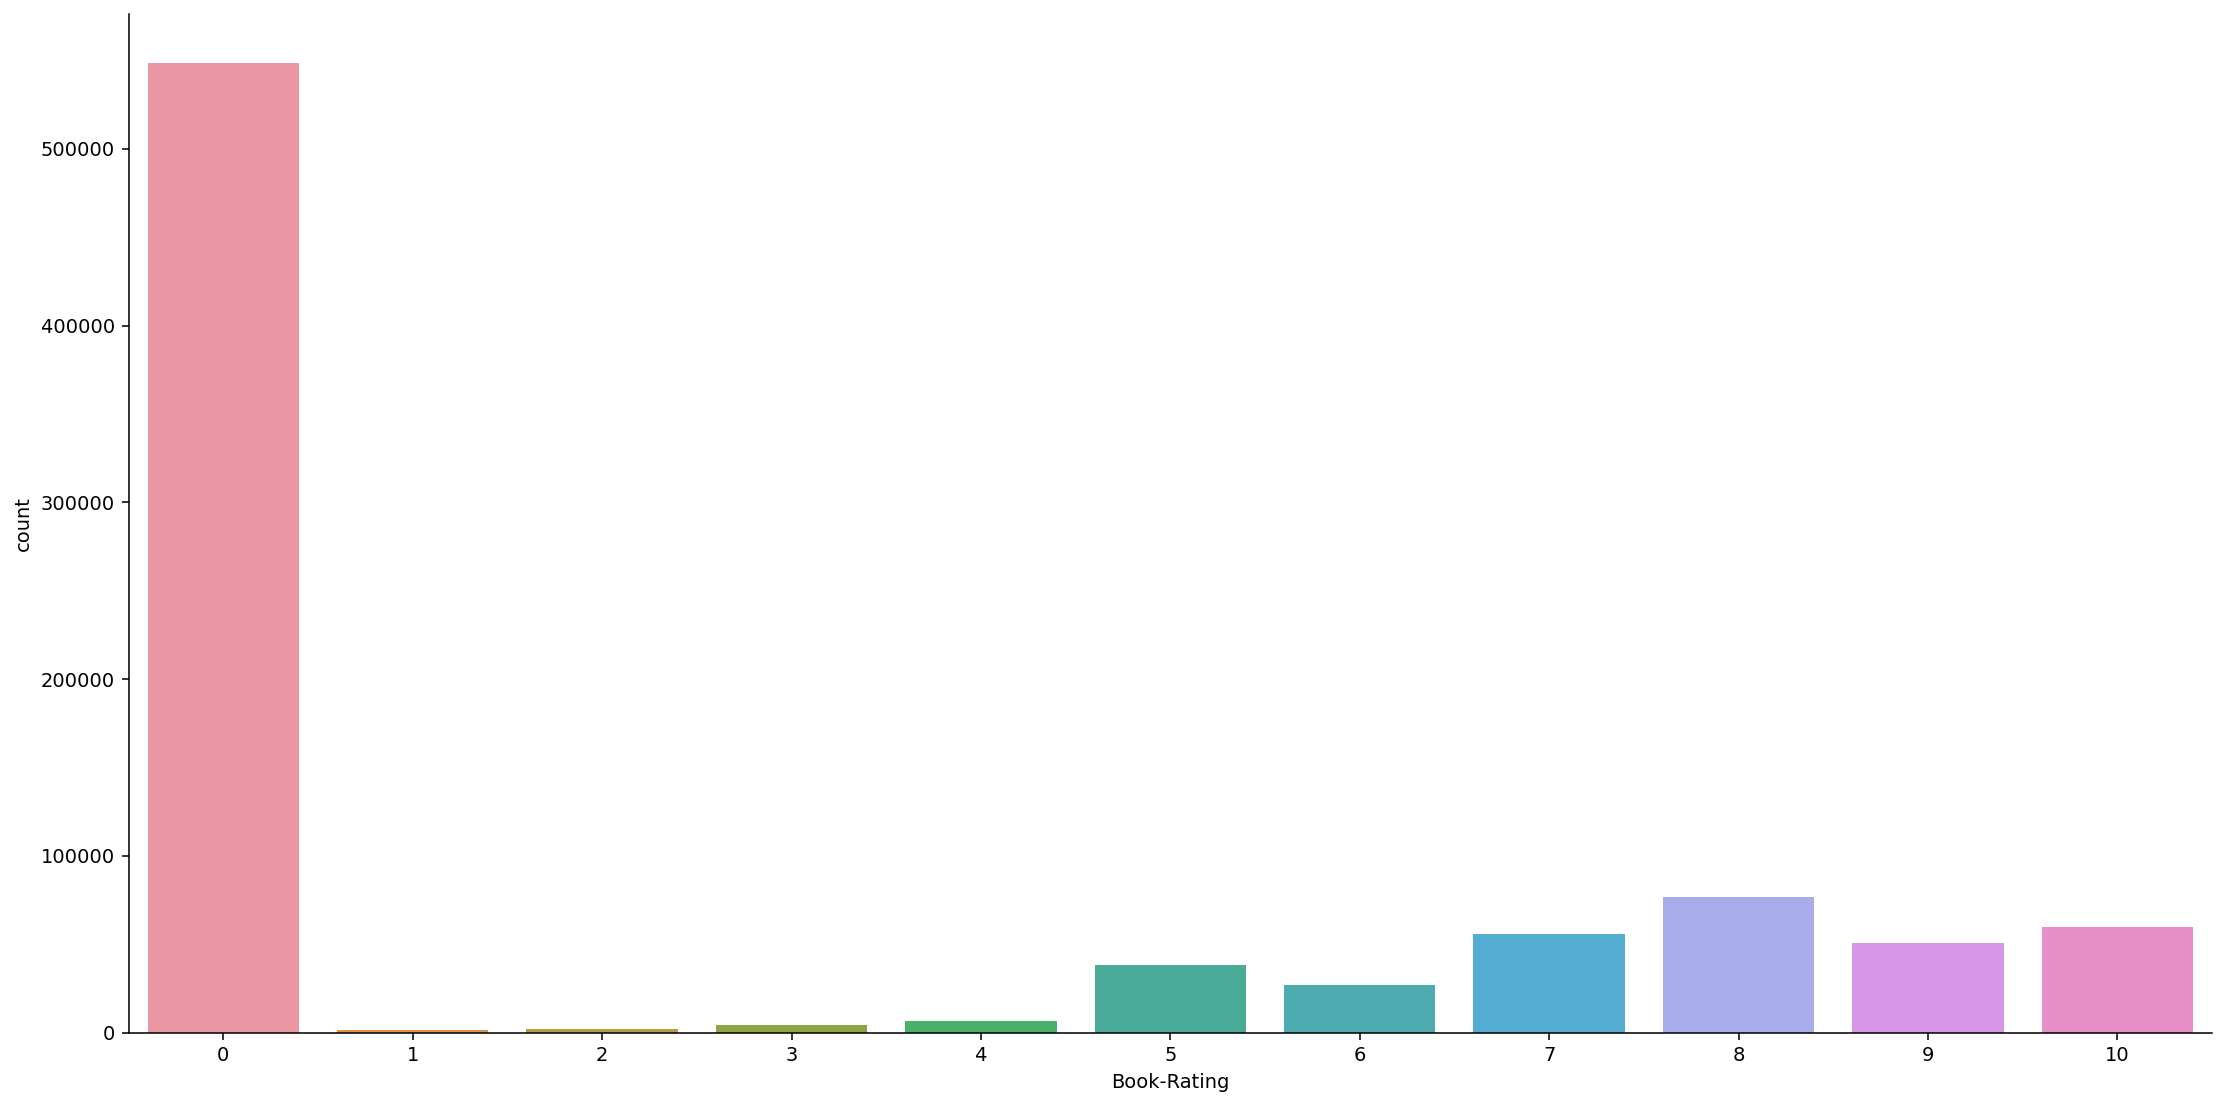

In [72]:
# Book-Rating 빈도
# sns.countplot(x='Book-Rating', data=train_df)
sns.catplot(x='Book-Rating', kind= 'count', data=train_df,height=8, aspect=2) 

In [212]:
train_df.head(3)

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Year-Of-Publication-Group,Age-Group
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira,2000+,19-29
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,1980,19-29
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,1980,19-29


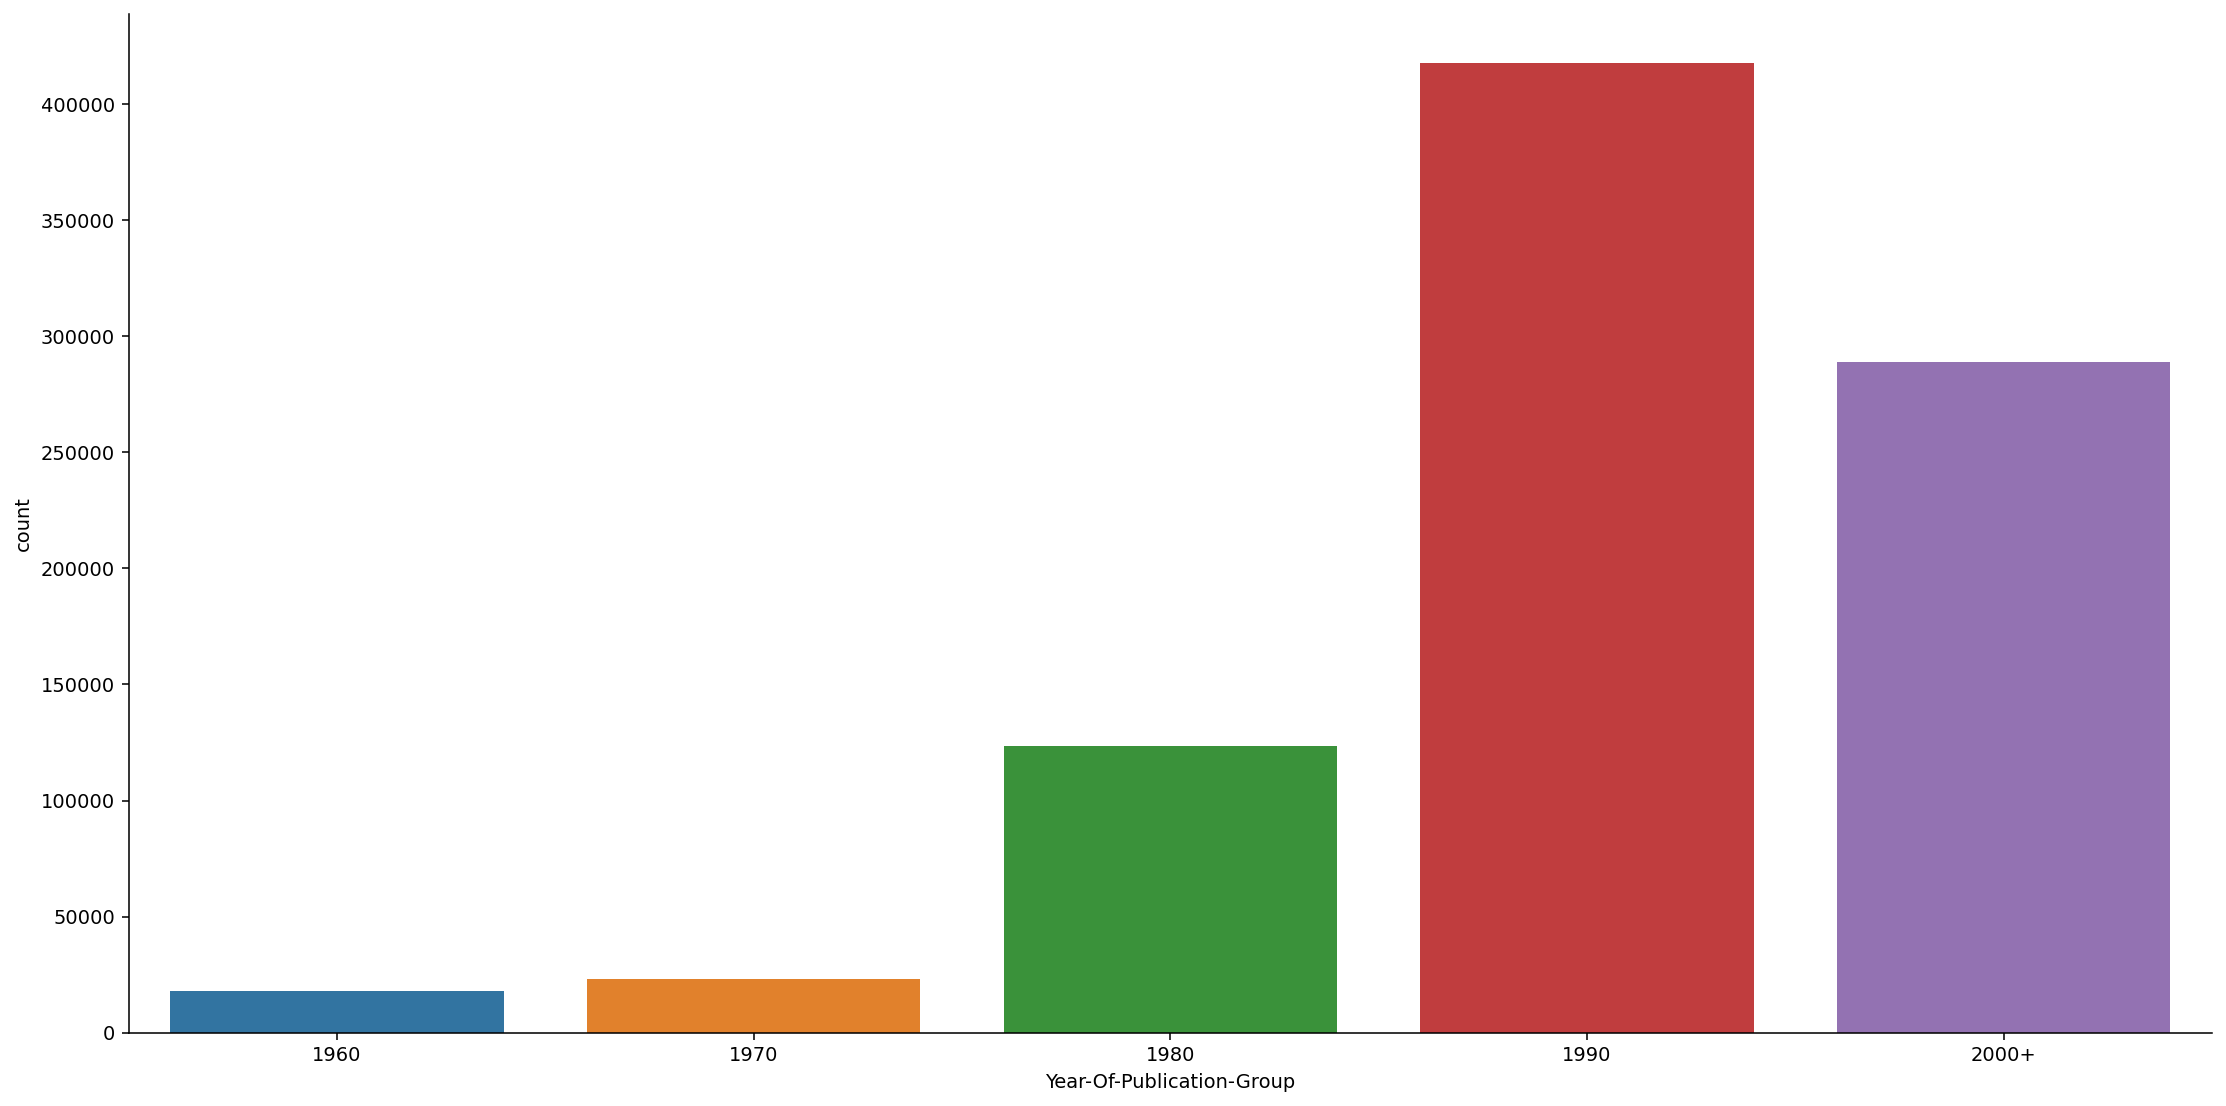

In [211]:
# 출판연도
sns.catplot(x='Year-Of-Publication-Group', kind= 'count', data=train_df, height=8, aspect=2) 

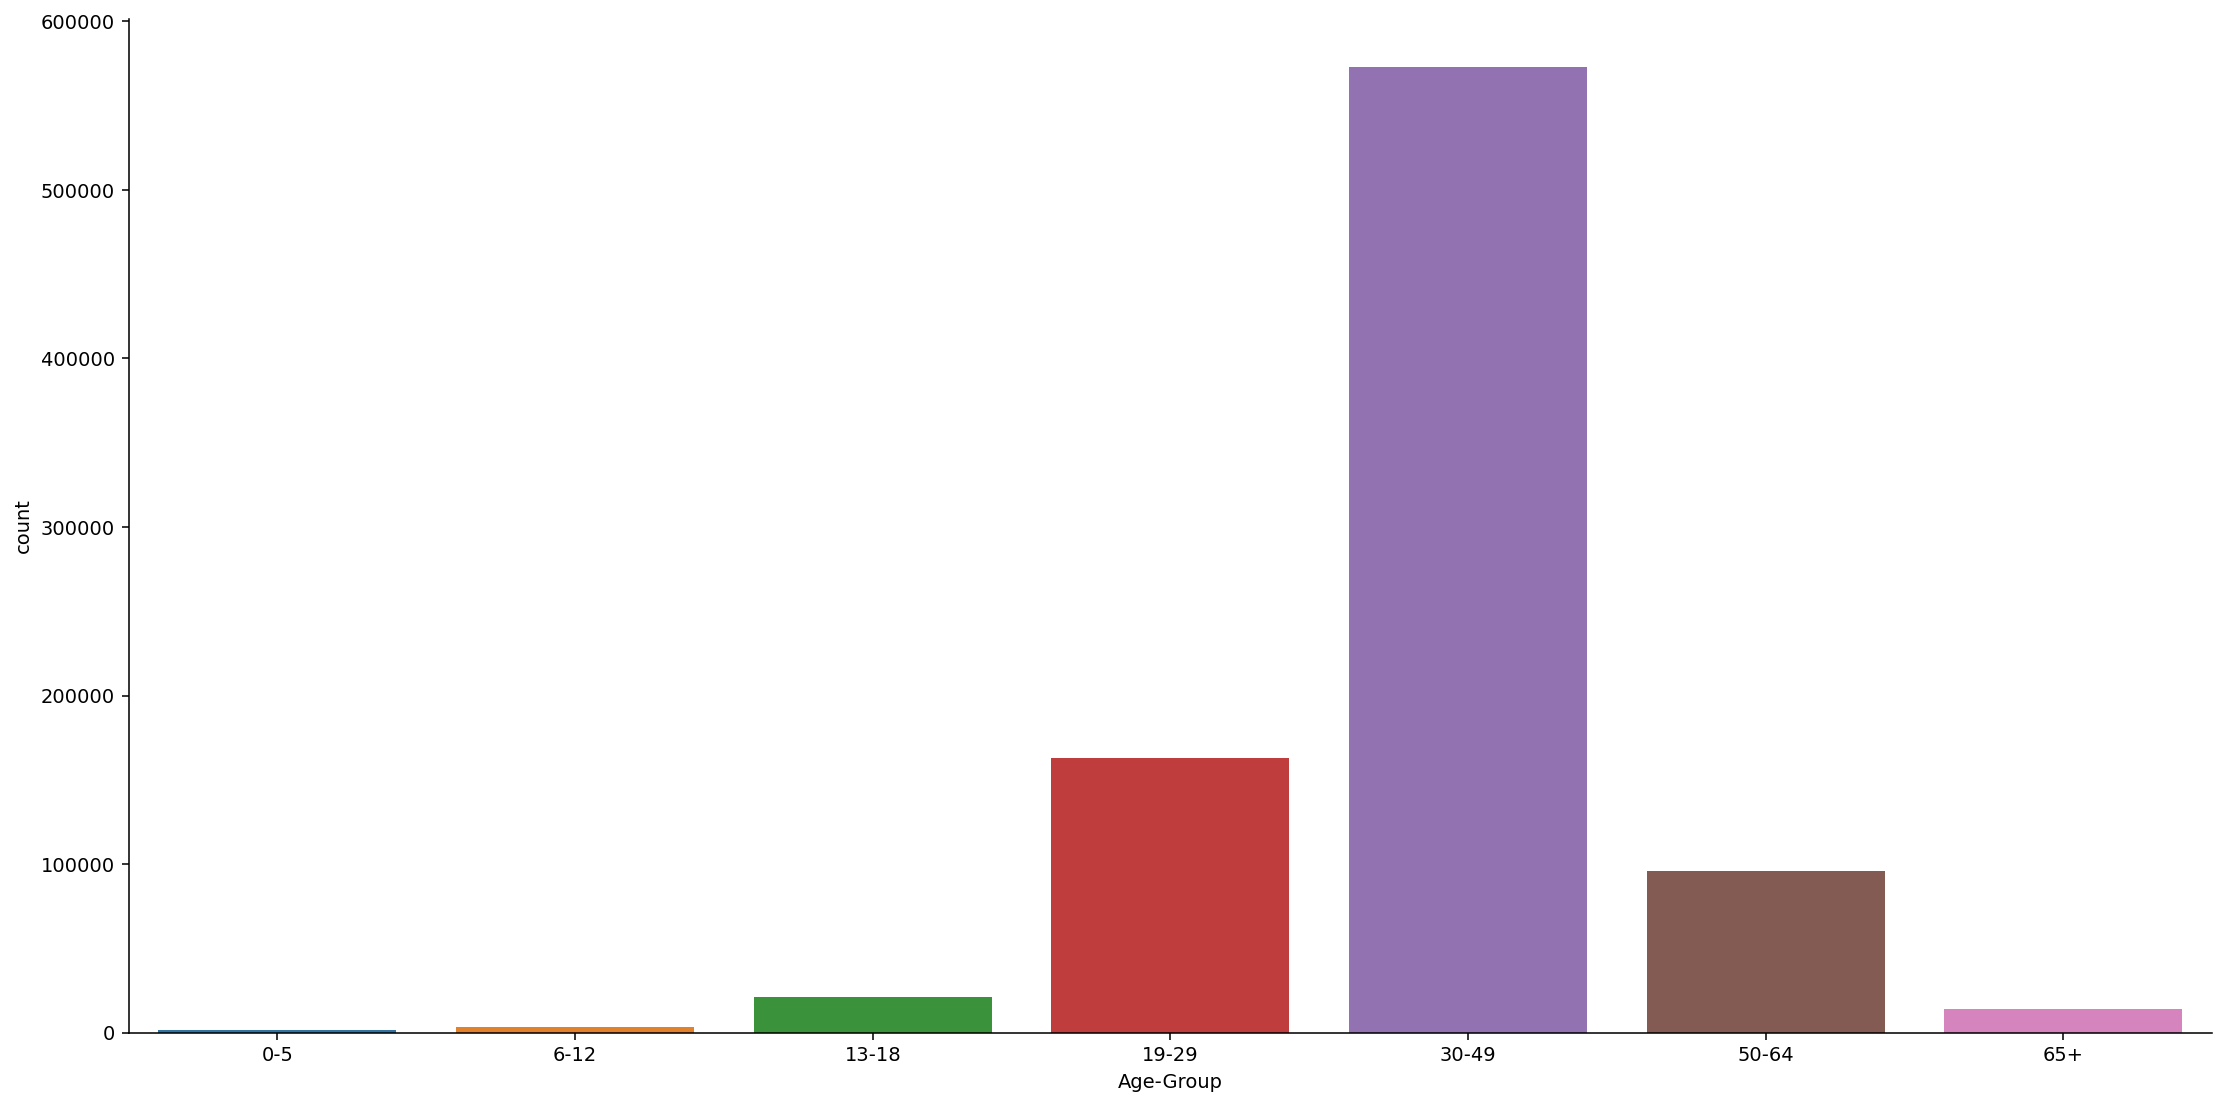

In [213]:
# 연령
sns.catplot(x='Age-Group', kind='count', data=train_df, height=8,aspect=2)

In [78]:
train_df['Book-Title'] = train_df['Book-Title'].astype('str')
train_df['Book-Author'] = train_df['Book-Author'].astype('str')

title_corpus = ' '.join(train_df['Book-Title'])
Author_corpus = ' '.join(train_df['Book-Author'])

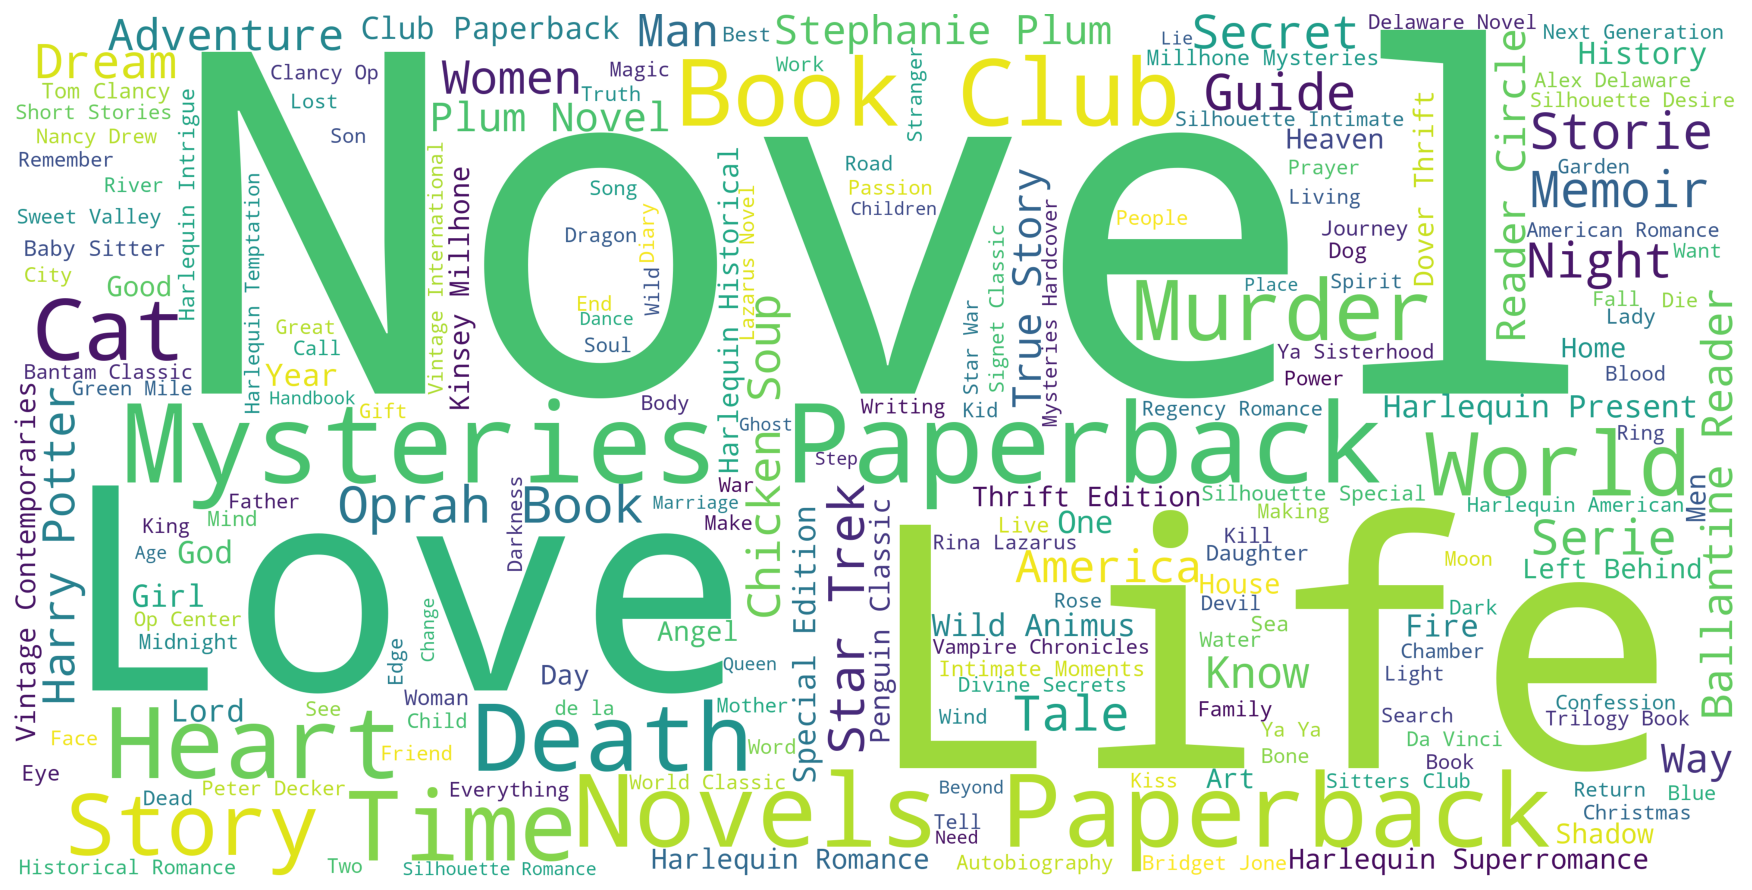

In [81]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()     

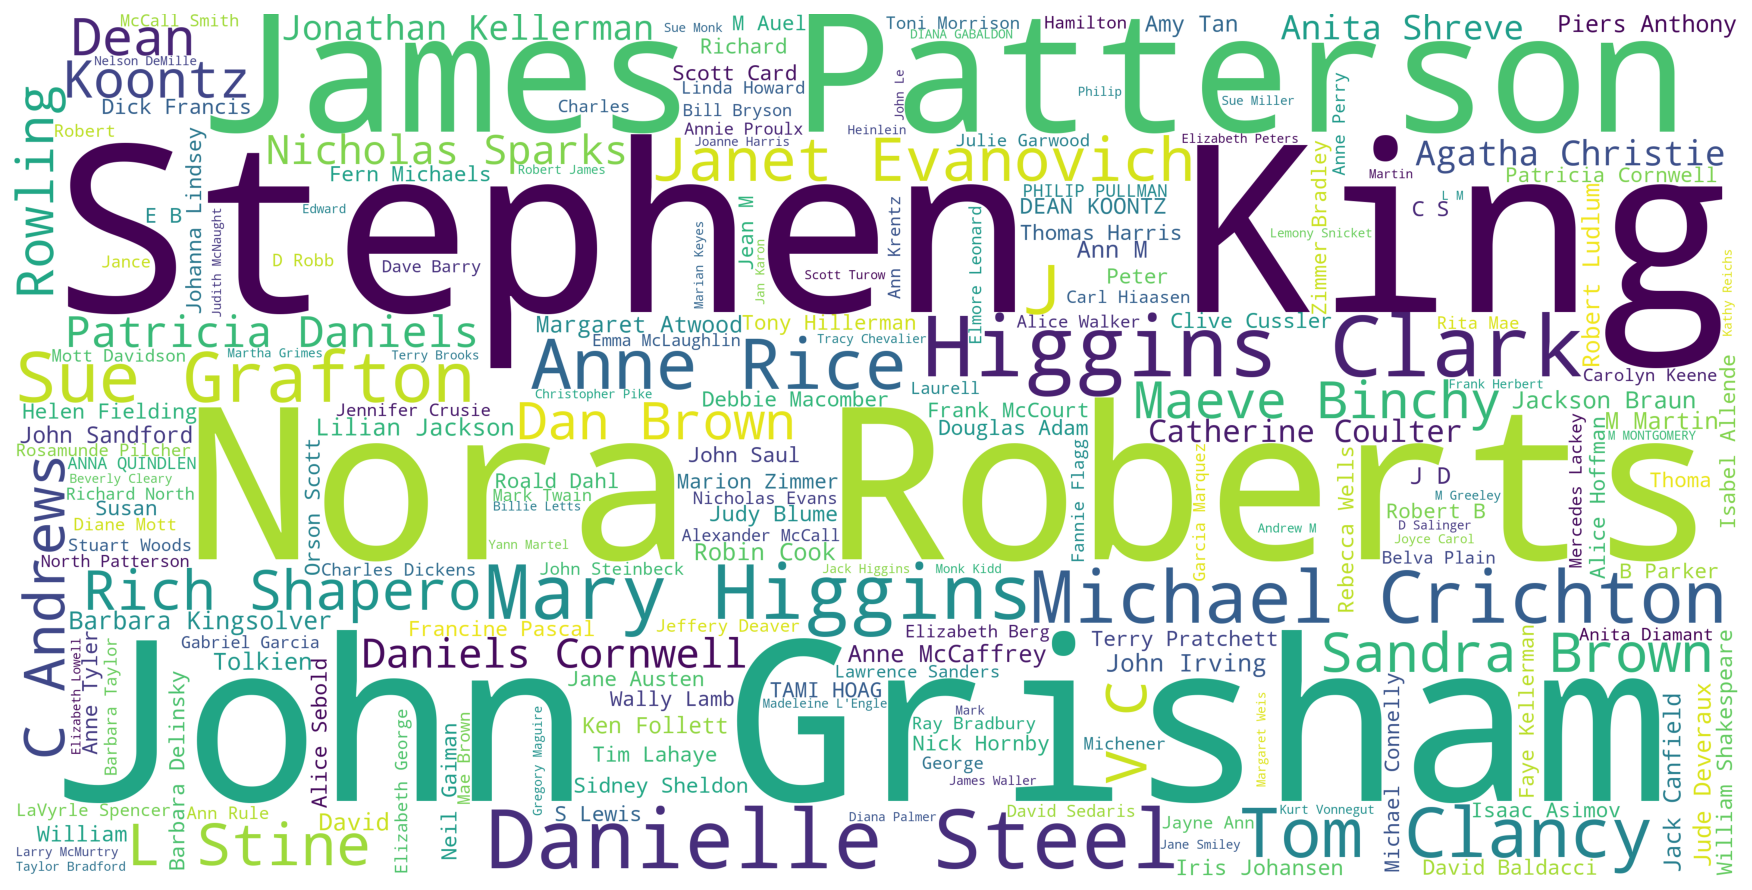

In [82]:
Author_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(Author_corpus)
plt.figure(figsize=(16,8))
plt.imshow(Author_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
###ing

In [215]:
Rating_Max=train_df.groupby(['Book-Title', 'Book-Rating'])['Book-Rating'].count().max(level=0)
Rating_Max=pd.DataFrame(Rating_Max)
Rating_Max=Rating_Max.reset_index()
Rating_Max.columns=['Book-Title','Rating_Max']
Rating_Max

C:\Users\lgh63\AppData\Local\Temp\ipykernel_25496\1952907836.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  Rating_Max=train_df.groupby(['Book-Title', 'Book-Rating'])['Book-Rating'].count().max(level=0)


,Book-Title,Rating_Max
0,A Light in the Storm: The Civil War Diary of ...,3
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
217824,Ã?Â?lpiraten.,2
217825,Ã?Â?rger mit Produkt X. Roman.,1
217826,Ã?Â?sterlich leben.,1
217827,Ã?Â?stlich der Berge.,2


In [216]:
train_df=pd.merge(train_df, Rating_Max,on='Book-Title',how='outer')
train_df

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Year-Of-Publication-Group,Age-Group,Rating_Max
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira,2000+,19-29,9
1,TRAIN_172879,USER_18605,BOOK_044368,0,44.0,"ft huachuca, arizona, usa",Road Taken,Rona Jaffe,2001.0,Mira,2000+,30-49,9
2,TRAIN_176634,USER_19119,BOOK_044368,0,38.0,"glen ellyn, illinois, usa",Road Taken,Rona Jaffe,2001.0,Mira,2000+,30-49,9
3,TRAIN_213643,USER_23578,BOOK_044368,0,49.0,"chantilly, virginia, usa",Road Taken,Rona Jaffe,2001.0,Mira,2000+,30-49,9
4,TRAIN_329292,USER_35257,BOOK_044368,6,43.0,"northglenn, colorado, usa",Road Taken,Rona Jaffe,2001.0,Mira,2000+,30-49,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
871388,TRAIN_871372,USER_92093,BOOK_262066,0,37.0,"lakewood, colorado, usa",Be Victorious (Be),Warren W. Wiersbe,1985.0,Victor Books,1980,30-49,1
871389,TRAIN_871376,USER_92093,BOOK_264287,0,37.0,"lakewood, colorado, usa",Prodigals and Those Who Love Them: Study Guide,Stephen Griffith,1991.0,Thomas Nelson Inc,1990,30-49,1
871390,TRAIN_871377,USER_92093,BOOK_264484,0,37.0,"lakewood, colorado, usa",A Transatlantic Love Affair: Letters to Nelson...,Simone De Beauvoir,1999.0,New Press,1990,30-49,1
871391,TRAIN_871378,USER_92093,BOOK_265220,0,37.0,"lakewood, colorado, usa",He's My Brother: Former Racial Foes Offer Stra...,John Perkins,1994.0,Baker Pub Group,1990,30-49,1


In [ ]:

from sklearn.preprocessing import LabelEncoder
qual_col = ['User-ID', 'Book-ID','Book-Title','Book-Author','Publisher','City','State','Country','Age_gb', 'Location']

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train_lb[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    test_lb[i] = le.transform(test_lb[i])  